In [12]:
import torch
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F

from torch import nn
from torchvision import datasets, transforms
from PIL import Image

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping

from keras import callbacks

In [3]:
# bez tego wysadza kernel kiedy rysuje obrazek
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
classes = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

device = "cuda"
batch_size = 64
torch.manual_seed(0)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()  # this includes scaling to [0, 1]
])

train_data = datasets.CIFAR10("./cifar10", download=True, transform=transform, train=True)
test_data = datasets.CIFAR10("./cifar10", download=True, transform=transform, train=False)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(train_data)
print(test_data)
print(train_data[0][0].size())
print(train_data[0][0])

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([3, 32, 32])
tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.

In [7]:
def print_img(img, axs):
    img_np = img.numpy()
    img_denormalized = (img_np*255).astype("uint8").transpose(1, 2, 0) 
    return axs.imshow(img_denormalized)

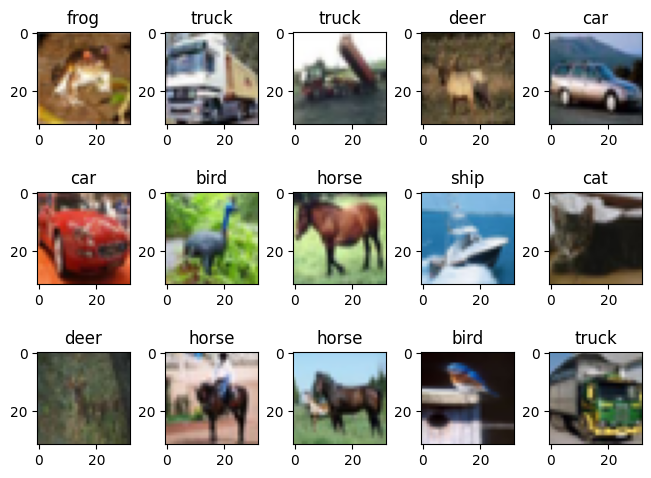

In [7]:
fig, axs = plt.subplots(3, 5, constrained_layout=True)
axs = np.reshape(axs, -1)
for x in range(15):
    img, label = train_data[x]
    axs[x].title.set_text(classes[label])
    print_img(img, axs[x])

In [16]:
def run_model(model):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)

    val_metrics = {
        "accuracy": Accuracy(),
        "loss": Loss(loss_fn)
    }

    train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
    val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        train_evaluator.run(train_loader)
        metrics = train_evaluator.state.metrics
        print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}")


    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        val_evaluator.run(test_loader)
        metrics = val_evaluator.state.metrics
        print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy'] * 100:.2f}%, Avg loss: {metrics['loss']:.2f}")

    def score_function(engine):
        metrics = engine.state.metrics
        return metrics["accuracy"]
    
    val_evaluator.add_event_handler(Events.COMPLETED, EarlyStopping(3, score_function, trainer))

    trainer.run(train_loader, max_epochs=15)

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
run_model(model)

Training Results - Epoch[1] Avg accuracy: 0.38 Avg loss: 1.78
Validation Results - Epoch[1] Avg accuracy: 0.38 Avg loss: 1.78
Training Results - Epoch[2] Avg accuracy: 0.43 Avg loss: 1.60
Validation Results - Epoch[2] Avg accuracy: 0.42 Avg loss: 1.62
Training Results - Epoch[3] Avg accuracy: 0.46 Avg loss: 1.52
Validation Results - Epoch[3] Avg accuracy: 0.45 Avg loss: 1.54
Training Results - Epoch[4] Avg accuracy: 0.48 Avg loss: 1.46
Validation Results - Epoch[4] Avg accuracy: 0.46 Avg loss: 1.50
Training Results - Epoch[5] Avg accuracy: 0.49 Avg loss: 1.43
Validation Results - Epoch[5] Avg accuracy: 0.47 Avg loss: 1.48


In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(32 * 20 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net().to(device)
run_model(model)

Training Results - Epoch[1] Avg accuracy: 50.86%, Avg loss: 1.37
Validation Results - Epoch[1] Avg accuracy: 49.93%, Avg loss: 1.41
Training Results - Epoch[2] Avg accuracy: 59.36%, Avg loss: 1.14
Validation Results - Epoch[2] Avg accuracy: 56.46%, Avg loss: 1.23
Training Results - Epoch[3] Avg accuracy: 63.20%, Avg loss: 1.03
Validation Results - Epoch[3] Avg accuracy: 58.69%, Avg loss: 1.16
Training Results - Epoch[4] Avg accuracy: 68.63%, Avg loss: 0.90
Validation Results - Epoch[4] Avg accuracy: 61.64%, Avg loss: 1.10
Training Results - Epoch[5] Avg accuracy: 71.88%, Avg loss: 0.79
Validation Results - Epoch[5] Avg accuracy: 62.25%, Avg loss: 1.09
Training Results - Epoch[6] Avg accuracy: 75.86%, Avg loss: 0.71
Validation Results - Epoch[6] Avg accuracy: 62.90%, Avg loss: 1.08
Training Results - Epoch[7] Avg accuracy: 79.70%, Avg loss: 0.59
Validation Results - Epoch[7] Avg accuracy: 62.63%, Avg loss: 1.12
Training Results - Epoch[8] Avg accuracy: 79.86%, Avg loss: 0.56
Validation 

2023-03-24 21:21:49,464 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[9] Avg accuracy: 59.74%, Avg loss: 1.37
